In [241]:
### Import
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from scipy.signal import find_peaks_cwt
#from hough_transform import detect_lanes
import time

%matplotlib inline

In [4]:
### Load Pickle Data
dist_data = pickle.load( open( "dist_pickle.p", "rb" ) )
camera_mtx = dist_data["mtx"]
camera_dist = dist_data["dist"]

In [253]:
### Load Images
images = glob.glob('test_images/*.jpg')

In [6]:
# Display Function
def disp_img(original_image, augmented_image, new_cmap=None, aug_title = ""):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(original_image)
    ax2.imshow(augmented_image, cmap=new_cmap)
    ax1.set_title('Original Image', fontsize=30)
    ax2.set_title('Augmented Image: ' + aug_title, fontsize=30)
    plt.show()

In [227]:

### Binary Thresholding Helper Functions
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    
    # Apply x or y gradient and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
        
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Apply a threshold, and create a binary image result
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    return dir_binary

def combined_binary_threshold(img, sobel_kernel=3, abs_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply functions
    gradx = abs_sobel_threshold(img, orient='x', sobel_kernel=sobel_kernel, abs_thresh=abs_thresh)
    grady = abs_sobel_threshold(img, orient='y', sobel_kernel=sobel_kernel, abs_thresh=abs_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, dir_thresh=dir_thresh)

    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_binary

In [8]:
'''
### Apply Binary Thresholding
gray = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)

# Individual Outputs
abs_sobel_thresh_imagex = abs_sobel_threshold(gray, orient='x', sobel_kernel=7, abs_thresh=(30, 100))
disp_img(undist_image, abs_sobel_thresh_imagex, new_cmap ="gray", aug_title = "Abs Thresh")

abs_sobel_thresh_imagey = abs_sobel_threshold(gray, orient='y', sobel_kernel=7, abs_thresh=(30, 100))
disp_img(undist_image, abs_sobel_thresh_imagey, new_cmap ="gray")

mag_thresh_image = mag_threshold(gray, sobel_kernel=7, mag_thresh=(30, 100))
disp_img(undist_image, mag_thresh_image, new_cmap ="gray", aug_title = "Mag Thresh")

dir_threshold_image = dir_threshold(gray, sobel_kernel=7, dir_thresh=(0.6, 1.3))
disp_img(undist_image, dir_threshold_image, new_cmap ="gray", aug_title = "Dir Thresh")
'''

'\n### Apply Binary Thresholding\ngray = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)\n\n# Individual Outputs\nabs_sobel_thresh_imagex = abs_sobel_threshold(gray, orient=\'x\', sobel_kernel=7, abs_thresh=(30, 100))\ndisp_img(undist_image, abs_sobel_thresh_imagex, new_cmap ="gray", aug_title = "Abs Thresh")\n\nabs_sobel_thresh_imagey = abs_sobel_threshold(gray, orient=\'y\', sobel_kernel=7, abs_thresh=(30, 100))\ndisp_img(undist_image, abs_sobel_thresh_imagey, new_cmap ="gray")\n\nmag_thresh_image = mag_threshold(gray, sobel_kernel=7, mag_thresh=(30, 100))\ndisp_img(undist_image, mag_thresh_image, new_cmap ="gray", aug_title = "Mag Thresh")\n\ndir_threshold_image = dir_threshold(gray, sobel_kernel=7, dir_thresh=(0.6, 1.3))\ndisp_img(undist_image, dir_threshold_image, new_cmap ="gray", aug_title = "Dir Thresh")\n'

In [9]:
### Color Space Analysis
'''
# Undistort test image
image = mpimg.imread(images[7])
undist_image = cv2.undistort(image, camera_mtx, camera_dist, None, camera_mtx)

# HLS
undist_hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
undist_L = undist_hls[:,:,1]
disp_img(undist_image, undist_L, new_cmap ="gray", aug_title = "L")
undist_S = undist_hls[:,:,2]
disp_img(undist_image, undist_S, new_cmap ="gray", aug_title = "S")

# HSV
undist_hsv = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HSV).astype(np.float)
undist_S = undist_hsv[:,:,1]
disp_img(undist_image, undist_S, new_cmap ="gray", aug_title = "S")
undist_V = undist_hsv[:,:,2]
disp_img(undist_image, undist_V, new_cmap ="gray", aug_title = "V")

# LAB - Yellow
undist_lab = cv2.cvtColor(undist_image, cv2.COLOR_RGB2Lab).astype(np.float)
undist_B = undist_lab[:,:,2]
disp_img(undist_image, undist_B, new_cmap ="gray", aug_title = "B")
'''

'\n# Undistort test image\nimage = mpimg.imread(images[7])\nundist_image = cv2.undistort(image, camera_mtx, camera_dist, None, camera_mtx)\n\n# HLS\nundist_hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)\nundist_L = undist_hls[:,:,1]\ndisp_img(undist_image, undist_L, new_cmap ="gray", aug_title = "L")\nundist_S = undist_hls[:,:,2]\ndisp_img(undist_image, undist_S, new_cmap ="gray", aug_title = "S")\n\n# HSV\nundist_hsv = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HSV).astype(np.float)\nundist_S = undist_hsv[:,:,1]\ndisp_img(undist_image, undist_S, new_cmap ="gray", aug_title = "S")\nundist_V = undist_hsv[:,:,2]\ndisp_img(undist_image, undist_V, new_cmap ="gray", aug_title = "V")\n\n# LAB - Yellow\nundist_lab = cv2.cvtColor(undist_image, cv2.COLOR_RGB2Lab).astype(np.float)\nundist_B = undist_lab[:,:,2]\ndisp_img(undist_image, undist_B, new_cmap ="gray", aug_title = "B")\n'

In [419]:
### Color Thresholding
def threshold(image, thresh_val):
    return cv2.threshold(image, thresh_val[0], thresh_val[1], cv2.THRESH_BINARY)

def color_threshold(img):
    
    # Channel based thresholding
    # HLS
    undist_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    undist_S = undist_hls[:,:,2]
    thresh_S = (180, 255)

    binary_hls_S = np.zeros_like(undist_S)
    _, binary_hls_S = threshold(undist_S, thresh_S)
    

    # LUV
    undist_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    undist_L = undist_luv[:,:,0]
    thresh_L = (225, 255)

    binary_luv_L = np.zeros_like(undist_L)
    _, binary_luv_L = threshold(undist_L, thresh_L)
    

    # LAB
    undist_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    undist_B = undist_lab[:,:,2]
    thresh_B = (150, 255)
    binary_lab_B = np.zeros_like(undist_B)
    _, binary_lab_B = threshold(undist_B, thresh_B)
    
    
    # Combined Color Thresholding
    combined_color_binary = np.zeros_like(binary_lab_B)
    
    #combined_color_binary[(binary_hls_S == 255) | (binary_luv_L == 255) | (binary_lab_B == 255)] = 255
    combined_color_binary[(binary_luv_L == 255) | (binary_lab_B == 255)] = 255
    return combined_color_binary

In [231]:
### Color Thresholding 2
def color_threshold2(img):
        
    # RGB color space to detect white line
    thresh_min  = np.array([ 200,  200,  200])
    thresh_max = np.array([ 255,  255, 255])
    
    # define mask for white line
    white_mask = cv2.inRange(img, thresh_min, thresh_max)
    
    # Apply mask
    white_line_img = cv2.bitwise_and(img, img, mask= white_mask).astype(np.uint8)
    
    # HSV Color Space to detect yellow line
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    hsv_v = hsv[:,:,2]
    
    thresh_min  = np.array([ 0,  100,  100])
    thresh_max = np.array([ 80, 255, 255])

    # Define mask for yellow line
    yellow_mask = cv2.inRange(hsv, thresh_min, thresh_max)
    
    # Apply mask
    yellow_line_img = cv2.bitwise_and(img, img, mask= yellow_mask).astype(np.uint8)

    # Combine masks
    combined_binary_mask = cv2.bitwise_or(yellow_mask, white_mask).astype(np.uint8)
    combined_binary = np.zeros_like(combined_binary_mask)
    combined_binary[combined_binary_mask > 0] = 1
    
    # HLS Color Space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls_l = hls[:,:,1]
    
    # Sobel for HLS - L    
    mag_binary = mag_threshold(hls_l, sobel_kernel=7, mag_thresh=(30, 255))
    dir_binary = dir_threshold(hls_l, sobel_kernel=7, dir_thresh=(0., 0.9))
    combined_sobel = np.zeros_like(dir_binary)
    combined_sobel[((mag_binary == 1) & (dir_binary > 0))] = 1

    # Threshold HSV - V
    hsv_binary = np.zeros_like(hsv_v)
    hsv_binary[(hsv_v >= 170) & (hsv_v <= 255)] = 1

    # Combined L and V Threshold
    combined_lv = np.zeros_like(hsv_v)
    combined_lv[((combined_sobel == 1) & (hsv_binary > 0))] = 1

    # Combine all
    combined_color_binary = np.zeros_like(combined_lv)    
    combined_color_binary[(combined_binary == 1) | (combined_lv == 1)] = 1 
     
    return combined_color_binary

In [162]:
### Perspective Transform

# Hough Transform to identify Src points
def hough_transform(img):
    hough_image, x_left1, x_left2, x_right1, x_right2 = detect_lanes(img)
    #plt.imshow(hough_image)
    
    return x_left1, x_left2, x_right1, x_right2


def undistort_img(image):
    # Undistort test image
    undist_image = cv2.undistort(image, camera_mtx, camera_dist, None, camera_mtx)

    img_size = (undist_image.shape[1], undist_image.shape[0])
    
    # Lane line vertices from Hough Transform
    #low_left_x, upper_left_x, low_right_x, upper_right_x = hough_transform(undist_image)
    #print(low_left_x, upper_left_x, low_right_x, upper_right_x)
    # Upper and low are based on visual locations, not grid locations
    center_x = img_size[0]//2
    upper_y = img_size[1]//1.5
    low_y = img_size[1]
    upper_left_x = center_x//1.33
    upper_right_x = center_x//0.80
    low_left_x = 0
    low_right_x = 2*center_x
    
    src_corners = np.float32([[low_left_x, low_y], 
                              [upper_left_x, upper_y], 
                              [upper_right_x, upper_y],
                              [low_right_x, low_y]])
   
    

    dst_corners = np.float32([[0, img_size[1]],
                              [0, 0],
                              [img_size[0],0],
                              [img_size[0], img_size[1]]])
    
    return undist_image, src_corners, dst_corners

def perspective_transform(image):
    
    undist_image, src_corners, dst_corners = undistort_img(image)
    
    
    img_size = (undist_image.shape[1], undist_image.shape[0])
    
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)

    warped = cv2.warpPerspective(undist_image, M, img_size)
    #plt.imshow(warped, cmap="gray")
    
    M_inv = cv2.getPerspectiveTransform(dst_corners, src_corners)

    
    for i in range(4):
        cv2.circle(undist_image, (src_corners[i,0], src_corners[i,1]), 6, (255, 0, 0), 6)
    for i in range(4):
        cv2.line(undist_image, 
                 (src_corners[i-1,0], src_corners[i-1,1]), 
                 (src_corners[i,0], src_corners[i,1]),  
                 (0,255,0), 2)
    
    #disp_img(undist_image, warped, new_cmap ="gray", aug_title = "Bird-Eye")
    
    return warped, M_inv

In [386]:
### Color Thresholding on Bird-Eye View

def thresholded_img(image):
    
    warped,M_inv = perspective_transform(image)
    blurred_warped = cv2.GaussianBlur(warped,(5,5),0)

    # Color Thresholding
    combined_color_binary = color_threshold(blurred_warped)

    disp_img(warped, combined_color_binary, new_cmap ="gray", aug_title = "Color Thresholded")
    
    return combined_color_binary, M_inv

In [466]:
### Lane Finding
def lane_coords(image):
    
    
    # Define image height and window size
    img_dim_y = image.shape[0]
    img_dim_x = image.shape[1]
    img_slices = 10
    win_size = img_dim_y//img_slices
    
    # Histogram
    indexes = []
    hist_val = []
    for i in range(img_slices):
        histogram = np.mean(image[(img_slices-i-1)*win_size:(img_slices-i)*win_size,:], axis=0)
        #plt.plot(histogram)
        start = time.time()
        
        #hist_peaks = find_peaks_cwt(histogram, np.arange(1, 500))
        left_half_min = img_dim_x//7.5
        left_half_max = img_dim_x//2.5
        right_half = img_dim_x-(img_dim_x//2.2)
        hist_peaksl = np.argmax(histogram[left_half_min:left_half_max])
        hist_peaksr = np.argmax(histogram[right_half:])
        #print(hist_peaksl+left_half_min)
        
        
        if histogram[hist_peaksl+left_half_min] > 0.01:
            hist_peaksl = int(hist_peaksl+left_half_min)
        else:
            hist_peaksl = 0
        
        if histogram[hist_peaksr + right_half] > 0.01:
            
        #and (hist_peaksr + right_half) > 800:
            hist_peaksr = int(hist_peaksr + right_half)
        else:
            hist_peaksr = 0   
        
        
        #print(hist_peaksr+right_half)
        #print(hist_peaksr)
        
        '''
        if hist_peaksl != 0 or hist_peaksr != 0:
            print("hist2: ", [hist_peaksl, hist_peaksr])
            print(histogram[hist_peaksl])
            print(histogram[hist_peaksr])
        '''
         
        indexes.append([hist_peaksl, hist_peaksr])
    
    #print(indexes)
    left_lane_idx = []
    right_lane_idx = []
    
    
    for i in range(img_slices):
        # Define window y positions
        win_y1 = (img_slices-i)*win_size
        win_y2 = (img_slices-i)*win_size - win_size        

        # Draw boxes and get indices of thresholded lane points
        # Left Lane
        if (indexes[i][0] != 0):
            # Define window x positions
            win_x1l = indexes[i][0] - (win_size//2)
            win_x2l = indexes[i][0] + (win_size//2)
            
            #cv2.rectangle(image, (win_x1l, win_y1), (win_x2l, win_y2), (0, 255, 0), 2)
            left_lane_idx_local = np.argwhere(image[win_y2:win_y1, win_x1l:win_x2l] > 0)
            # Append to list of lane indices and apply frame of reference transformation
            left_lane_idx.append(left_lane_idx_local + [win_y2,win_x1l])

        # Right lane
        if(indexes[i][1] != 0):
            # Define window x positions
            win_x1r = indexes[i][1] - (win_size//2)
            win_x2r = indexes[i][1] + (win_size//2)
        
            #cv2.rectangle(image, (win_x1r, win_y1), (win_x2r, win_y2), (0, 255, 0), 2)
            right_lane_idx_local = np.argwhere(image[win_y2:win_y1, win_x1r:win_x2r] > 0)
            
            # Append to list of lane indices and apply frame of reference transformation
            right_lane_idx.append(right_lane_idx_local + [win_y2,win_x1r])            

    left_lane_idx = np.concatenate(left_lane_idx[:], axis=0)
    right_lane_idx = np.concatenate(right_lane_idx[:], axis=0)
    #left_lane_idx = np.concatenate(([[img_dim_y, 0]],left_lane_idx), axis=0)
    
    #right_lane_idx = np.concatenate(([[img_dim_y, right_lane_idx[0][1]]], right_lane_idx), axis=0)
    #right_lane_idx = np.concatenate((right_lane_idx, [[0, right_lane_idx[-1][1]]]), axis=0)
    #plt.imshow(image)
    
    return left_lane_idx, right_lane_idx

In [319]:
### Draw Lane Points on new image
def draw_lane_points(img, left_lane_idx, right_lane_idx):
    
    new_img = np.zeros_like(img)
    for i in range(len(left_lane_idx)):
        for j in range(len(left_lane_idx[i])):
            cv2.circle(new_img, (left_lane_idx[i][1],left_lane_idx[i][0]), 1, (255, 255, 0), 1)

    for i in range(len(right_lane_idx)):
        cv2.circle(new_img, (right_lane_idx[i][1],right_lane_idx[i][0]), 1, (255, 0, 0), 1)
    
    return new_img
        


In [482]:
### Fit lane lines

def identify_lane(left_lane_idx, right_lane_idx, img_size):
    
    left_lane_y = np.array([item[0] for item in left_lane_idx])
    left_lane_x = np.array([item[1] for item in left_lane_idx])
    right_lane_y = np.array([item[0] for item in right_lane_idx])
    right_lane_x = np.array([item[1] for item in right_lane_idx])

    # Fit a second order polynomial to lane line
    left_fit = np.polyfit(left_lane_y , left_lane_x, 2)
    left_fit_x = left_fit[0]*left_lane_y **2 + left_fit[1]*left_lane_y  + left_fit[2]
    
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fit_x = right_fit[0]*right_lane_y**2 + right_fit[1]*right_lane_y + right_fit[2]
    

    
    # Extrapolation of left lane
    top_left_y = top_right_y = 0
    bottom_left_y = bottom_right_y = img_size[1]
    
    top_left_x = left_fit[0]*top_left_y**2 + left_fit[1]*top_left_y  + left_fit[2]
    bottom_left_x = left_fit[0]*bottom_left_y**2 + left_fit[1]*bottom_left_y  + left_fit[2]
    
    left_fit_x = np.append(np.flipud(left_fit_x), top_left_x)
    left_lane_y = np.append(np.flipud(left_lane_y), top_left_y)
    
    left_fit_x = np.append(np.flipud(left_fit_x), bottom_left_x)
    left_lane_y = np.append(np.flipud(left_lane_y), bottom_left_y)
    
    
    
    # Use previous frames to keep track of right lane
    if len(right_lane_x)<1000 and right_fit_count==10:
        right_fit = prev_right_fit
    elif right_fit_count < 10:
        right_fit_count += 1
        prev_right_fit = right_fit
        
    '''
    right_fit = np.polyfit(right_lane_x, right_lane_y ,1)
    right_slope, right_intercept = np.polyfit(right_lane_x, right_lane_y ,1)
    right_fit_x = (right_lane_y - right_fit[1])/right_fit[0]

    top_right_x = (top_right_y - right_intercept)/right_slope
    bottom_right_x = (bottom_right_y - right_intercept)/right_slope

    right_fit_x = np.append(np.flipud(right_fit_x), top_right_x)
    right_lane_y = np.append(np.flipud(right_lane_y), top_right_y)

    right_lane_y = np.append(np.flipud(right_lane_y), bottom_right_y)
    right_fit_x = np.append(np.flipud(right_fit_x), bottom_right_x)
    '''
    
    #right_fit = np.polyfit(right_lane_y, right_lane_x, 3)
    #right_fit_x = right_fit[0]*right_lane_y**3 + right_fit[1]*right_lane_y**2 + right_fit[2]*right_lane_y + right_fit[3]

    

    #top_right_x = right_fit[0]*top_right_y**3 + right_fit[1]*top_right_y**2 + right_fit[2]*top_right_y + right_fit[3]
    #bottom_right_x = right_fit[0]*bottom_right_y**3 + right_fit[1]*bottom_right_y**2 + right_fit[2]*bottom_right_y + right_fit[3]

    top_right_x = right_fit[0]*top_right_y**2 + right_fit[1]*top_right_y + right_fit[2]
    bottom_right_x = right_fit[0]*bottom_right_y**2 + right_fit[1]*bottom_right_y + right_fit[2]
    
    right_fit_x = np.append(np.flipud(right_fit_x), top_right_x)
    right_lane_y = np.append(np.flipud(right_lane_y), top_right_y)

    right_lane_y = np.append(np.flipud(right_lane_y), bottom_right_y)
    right_fit_x = np.append(np.flipud(right_fit_x), bottom_right_x)
    
    
    
    
    
    #print("lane", bottom_right_x)
    #print(right_fit_x[-6:-2])
    return left_lane_y, right_lane_y, left_fit_x, right_fit_x, left_fit, right_fit

'''
# Plot lanes
plt.plot(left_fitx, left_lane_y, color='green', linewidth=3)
plt.plot(right_fitx, right_lane_y, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
'''

"\n# Plot lanes\nplt.plot(left_fitx, left_lane_y, color='green', linewidth=3)\nplt.plot(right_fitx, right_lane_y, color='green', linewidth=3)\nplt.gca().invert_yaxis() # to visualize as we do the images\n"

In [324]:
def draw_curved_line(img, line_fit):
    
    p = np.poly1d(line_fit)
    x = list(range(0, img.shape[0]))
    y = list(map(int, p(x)))
    points = np.array([[y1,x1] for x1, y1 in zip(x, y)])
    points = points.reshape((-1,1,2))
    cv2.polylines(img, np.int32([points]), False, color=(255,0,0), thickness=50)


In [422]:
# Plot lane over original image

def draw_lane_line(image, left_lane_y, right_lane_y, left_fit_x, right_fit_x, M_inv):

    combined_lane_left = np.array([np.flipud((np.transpose(np.vstack((left_fit_x,left_lane_y)))))])
    combined_lane_right = np.array([np.transpose(np.vstack((right_fit_x,right_lane_y)))])
    combined_lane_idx = np.hstack((combined_lane_left,combined_lane_right))
    #print("left top: ", combined_lane_left[0][0])
    #print("left bottom: ", combined_lane_left[0][-1])
    #print("right top: ", combined_lane_right[0])
    #print("right bottom: ", combined_lane_right[-1])
    #print(len(combined_lane_left))
    #print(len(combined_lane_left[0]))

    img_draw = np.zeros_like(image)
    cv2.polylines(img_draw, np.int_([combined_lane_idx]), isClosed=False, color=(0,0,255), thickness = 30)
    cv2.fillPoly(img_draw, np.int_([combined_lane_idx]), (0,255, 0))
    new_warp = cv2.warpPerspective(img_draw, M_inv, (image.shape[1], image.shape[0]))
    new_img = cv2.addWeighted(image, 1, new_warp, 0.5, 0)
    #plt.imshow(new_img)
    return new_img


In [479]:
### Image pipeline
def process_image(image):
    
    global prev_right_fit, right_fit_count
    
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    thresholded_image, M_inv = thresholded_img(image)
    img_size = [image.shape[1], image.shape[0]]
    
    left_lane_idx, right_lane_idx = lane_coords(thresholded_image)
    left_lane_y, right_lane_y, left_fit_x, right_fit_x, left_fit, right_fit = identify_lane(left_lane_idx, right_lane_idx, img_size)
    img_test = draw_lane_points(thresholded_image, left_lane_idx, right_lane_idx)
    #draw_curved_line(thresholded_image, right_fit)
    
    final_img = draw_lane_line(image, left_lane_y, right_lane_y, left_fit_x, right_fit_x, M_inv)
    
    #plt.imshow(thresholded_image)
    
    #print(right_fit_x)
    
    return final_img

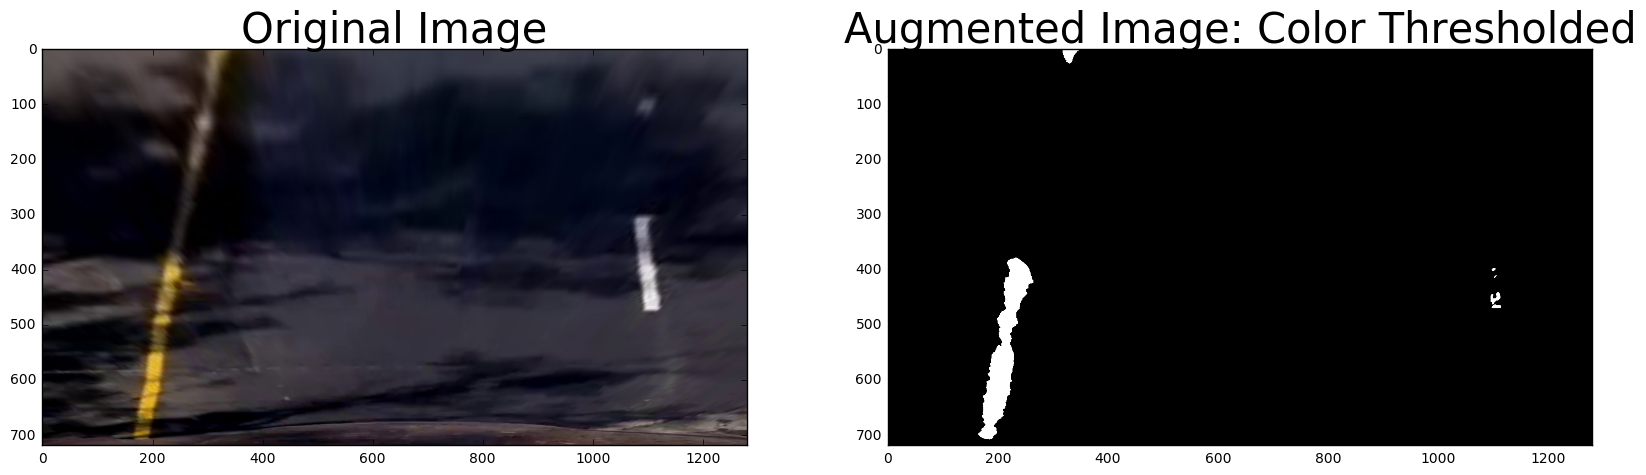

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


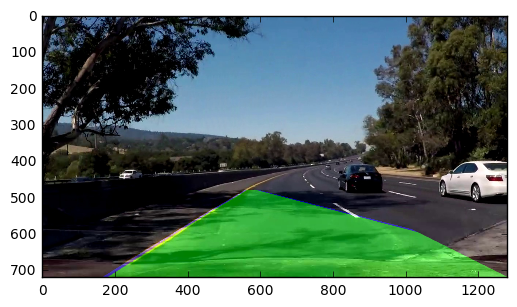

In [489]:
### Run Pipeline on test image

# Test images
'''
fig = plt.figure(figsize=(20, 8))
r = 1
for i in range(7):
    if r < 7:
        fig.add_subplot(2,3,r)
        image = cv2.imread(images[i])
        final_img = process_image(image)
        plt.imshow(final_img)
        r += 1
plt.show
'''
#image = cv2.imread(images[0])
image = cv2.imread('test_images/frame1039.jpg')
final_img = process_image(image)
plt.imshow(final_img)



In [378]:
vidcap = cv2.VideoCapture("project_video.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    if 1000 < count < 1100:
        cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

In [ ]:
### Prrocess video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

right_fit_count = 0

output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

In [ ]:
'''
try:
    # Undistort test image
    image = cv2.imread(images[5])
    undist_image = cv2.undistort(image, camera_mtx, camera_dist, None, camera_mtx)
    blurred_warped = cv2.GaussianBlur(warped,(5,5),0)

    def color_thresh_test(img, colorspace = cv2.COLOR_BGR2HLS, threshold_min = 140, channel = 0):

        img_convert = cv2.cvtColor(img, colorspace)
        img_ch = img_convert[:,:,channel]
        #gray_warped = cv2.cvtColor(img_ch, cv2.COLOR_RGB2GRAY)
        #binary_img = combined_binary_threshold(img_ch, sobel_kernel=7, abs_thresh=(threshold_min, 255), 
                                                            #mag_thresh=(threshold_min, 255), dir_thresh=(0.1, 0.9))
        
        thresh = (threshold_min, 255)
        
        
        binary_img = np.zeros_like(img_ch)
        ret, binary_img = cv2.threshold(img_ch, thresh[0], thresh[1], cv2.THRESH_BINARY)
        #binary_img[((img_ch > thresh[0]) & (img_ch <= thresh[1]))] = 255
        
        return binary_img

    cv2.namedWindow('image')

    def nothing(x):
        pass

    # Create slider/trackbar for threshold min/max
    cv2.createTrackbar('Threshold','image',0,255,nothing)


    # Allocate destination image
    threshold_image = np.zeros_like(warped)
    while(1):

        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break

        # Get threshold value
        threshold_val = cv2.getTrackbarPos('Threshold','image')

        threshold_image = color_thresh_test(warped, colorspace = cv2.COLOR_BGR2HLS, threshold_min = threshold_val, channel = 2)
        cv2.imshow('image', threshold_image)
    cv2.destroyAllWindows()
except:
    print("error")
    cv2.destroyAllWindows()
'''